In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Berger Viscous Equation parameters
c = 1.0    # Wave speed
mu = 0.1   # Viscosity coefficient
lam = 1.0  # Nonlinearity coefficient

# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential(*[
            nn.Sequential(nn.Linear(layers[i], layers[i+1]), nn.Tanh())
            for i in range(len(layers)-2)
        ] + [nn.Linear(layers[-2], layers[-1])])

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.net(inputs)

# Compute PDE residual using automatic differentiation
def compute_pde_residual(model, x, t):
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    u = model(x, t)  # Predict u(x, t)
    
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    f = u_tt - c**2 * u_xx - mu * u_xx + lam * u * u_xx  # PDE residual
    return f

# Importance sampling: Generate collocation points based on residuals
def generate_collocation_points(model, N_f, L=1.0, T=1.0):
    x_f = torch.rand(N_f, 1, device=device, requires_grad=True) * L  # x in [0, L]
    t_f = torch.rand(N_f, 1, device=device, requires_grad=True) * T  # t in [0, T]
    
    if model is not None:  # Perform importance sampling
        residuals = compute_pde_residual(model, x_f, t_f).detach()
        probabilities = residuals.abs() / torch.sum(residuals.abs())  # Normalize to form a probability distribution
        sampled_indices = torch.multinomial(probabilities.view(-1), N_f, replacement=True)
        x_f, t_f = x_f[sampled_indices], t_f[sampled_indices]
    
    return x_f, t_f


# Training loop with dynamic importance sampling




In [3]:
def fit_GP(x,t):
    kernel = C(1.0) * RBF(length_scale=1.0)

# Create the Gaussian Process Regressor
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    x_0 = x.cpu().detach().numpy() 
    t_0 = t.cpu().detach().numpy()
    gp.fit(x_0,t_0)
    y_pred, sigma = gp.predict(x_0, return_std=True)
    
    most_uncertain_indices = np.argsort(-sigma)[:100]  # Sort in descending order and take top 100
    most_uncertain_points = x_0[most_uncertain_indices]

    most_uncertain_indices = torch.tensor(most_uncertain_points,device=device, requires_grad=True)
    most_uncertain_points=torch.tensor(most_uncertain_points, device=device, requires_grad=True)
    return most_uncertain_points,most_uncertain_indices
    



In [4]:
def fit_GP(model,x,t):
    # Evaluate residuals at collocation points
    residuals = compute_pde_residual(model,x, t).cpu().detach().numpy()

# Convert collocation points to NumPy for sklearn GP
    collocation_np = np.hstack((x.cpu().detach().numpy(), t.cpu().detach().numpy()))

# Define Gaussian Process kernel (constant term + RBF)
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process to residuals
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=5)
    gp.fit(collocation_np, residuals)

    print("GP Training Done!")
    return gp



In [5]:

# def gen_Hi_Points(model, x, t, num_new_points=100, expand_factor=5, domain_x=(-1,1), domain_t=(0,1), device='cpu'):
import numpy as np
import torch
def gen_Hi_Points(model, x, t,num_new_points=100, expand_factor=10):
# def gen_Hi_Points(model, x, t, num_new_points=100, expand_factor=5,device='cpu'):
    """
    Generates new collocation points focusing on uncertain regions.
    
    - `num_new_points`: Base number of new points (further expanded via `expand_factor`).
    - `expand_factor`: Controls the number of additional sampled points around high-variance points.
    """
    domain_x=(-1,1)
    domain_t=(0,1)
    # Fit Gaussian Process
    gp = fit_GP(model,x,t)
    x_dense = np.linspace(-1, 1, 50).reshape(-1, 1)
    t_dense = np.linspace(0, 1, 50).reshape(-1, 1)
    X, T = np.meshgrid(x_dense, t_dense)
    dense_points = np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))

    # Predict residual variance using GP
    residual_mean, residual_std = gp.predict(dense_points, return_std=True)

    # Identify high-uncertainty regions
    high_var_indices = np.argsort(residual_std)[-100:]  # Select top 10 uncertain points
    high_var_points = torch.tensor(dense_points[high_var_indices], dtype=torch.float32)  # Extract corresponding (x,t)
    # new_points = torch.tensor(dense_points[high_var_indices], dtype=torch.float32)
    # Generate additional points near high-variance locations
    additional_points = []
    for point in high_var_points:
        x_c, t_c = point
        for _ in range(expand_factor):  # Generate `expand_factor` points per high-variance point
            new_x = np.random.normal(x_c, 0.1)  # Small perturbation in x
            new_t = np.random.normal(t_c, 0.1)  # Small perturbation in t
            additional_points.append([new_x, new_t])

    # Convert new points to tensor
    new_points = torch.tensor(np.array(additional_points), dtype=torch.float32).to(device)
    x_new, t_new = new_points[:, 0].reshape(-1, 1).to(device), new_points[:, 1].reshape(-1, 1).to(device)

    # Ensure points are within bounds
    x_new = torch.clamp(x_new, min=domain_x[0], max=domain_x[1]).to(device)
    t_new = torch.clamp(t_new, min=domain_t[0], max=domain_t[1]).to(device)

    # Move to device
    x_new, t_new = x_new.to(device), t_new.to(device)

    # Merge with existing collocation points
    # x_collocation = torch.cat([x.to(device), x_new]).to(device)
    # t_collocation = torch.cat([t.to(device), t_new]).to(device)

    print(f"Updated Collocation Points with {len(new_points)} Additional GP-Guided Samples!")
    print(x_new.shape, t_new.shape, x.shape, t.shape)
    return x_new, t_new



In [6]:
# Define loss function
def loss_function(model, x_f, t_f, x_bc, t_bc, u_bc):
    f_residual = compute_pde_residual(model, x_f, t_f)
    loss_pde = torch.mean(f_residual**2)

    u_pred_bc = model(x_bc, t_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_pde + loss_bc
def train(model, optimizer, N_f, x_bc, t_bc, u_bc, epochs=5000, resample_every=500):
    x_f, t_f = generate_collocation_points(model, N_f)
    for epoch in range(epochs):
        
           
        
        optimizer.zero_grad()
        loss = loss_function(model, x_f, t_f, x_bc, t_bc, u_bc)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            # x_f,t_f = fit_GP(x_f,t_f)
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            x_uncertain, t_uncertain = gen_Hi_Points(model,x_f, t_f) 
            x_f = x_uncertain
            t_f = t_uncertain

In [7]:
# Define PINN model architecture
layers = [2, 50, 50, 50, 1]  # Input (x,t) -> Hidden layers -> Output (u)
model = PINN(layers).to(device)

# Define boundary and initial conditions
N_f = 1000  # Collocation points
L, T = 1.0, 1.0  # Spatial and time limits

x_f, t_f = generate_collocation_points(None, N_f, L, T)  # Initial uniform sampling

# Boundary conditions (u(x, 0) = sin(pi x), u(0, t) = 0, u(L, t) = 0)
N_bc = 100
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)  # Initial condition

# Train the model with importance sampling
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, N_f, x_bc, t_bc, u_bc, epochs=10000, resample_every=100)

# Visualize results
x_test = torch.linspace(0, L, 100).view(-1, 1).to(device)
t_test = torch.linspace(0, T, 100).view(-1, 1).to(device)

x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
x_flat, t_flat = x_grid.flatten().view(-1, 1), t_grid.flatten().view(-1, 1)

u_pred = model(x_flat, t_flat).detach().cpu().numpy().reshape(100, 100)

/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.5544387698173523


/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 500, Loss: 0.0003633145825006068
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 1000, Loss: 0.011682773008942604
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 1500, Loss: 0.0025298167020082474
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 2000, Loss: 0.0030309376306831837
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])

/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 3500, Loss: 9.653441520640627e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 4000, Loss: 0.000396242190618068


/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 4500, Loss: 7.553273462690413e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 5000, Loss: 0.0002579287101980299
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 5500, Loss: 4.777734284289181e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 6000, Loss: 0.0002408598957117647


/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 6500, Loss: 3.8964666600804776e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 7000, Loss: 0.00012502014578785747
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 7500, Loss: 3.131825724267401e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 8000, Loss: 0.00021795748034492135


/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 8500, Loss: 2.03931540454505e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 9000, Loss: 0.00031067460076883435
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
Epoch 9500, Loss: 3.5777797165792435e-05
GP Training Done!
Updated Collocation Points with 1000 Additional GP-Guided Samples!
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


In [8]:
#Loss on general function
x_f, t_f = generate_collocation_points(model, 1000,L,T)
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)

loss_function(model, x_f, t_f, x_bc, t_bc, u_bc).item()

54.81053161621094

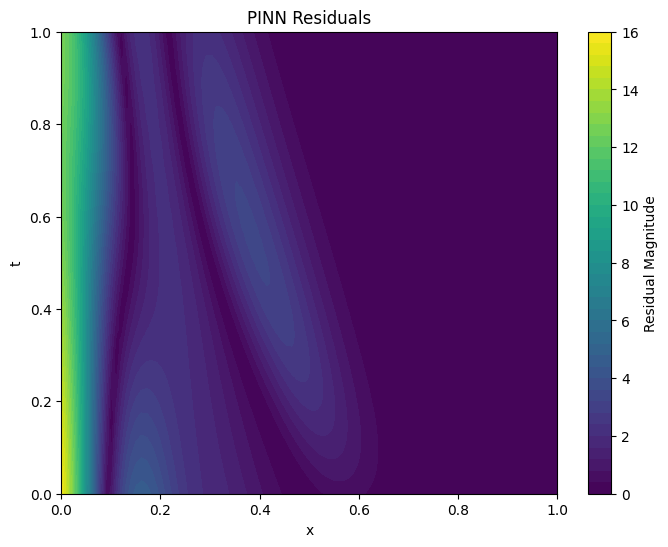

In [9]:
def plot_residuals(model, x_range=(0, 1), t_range=(0, 1), num_points=100):
    x_test = torch.linspace(x_range[0], x_range[1], num_points).view(-1, 1).to(device)
    t_test = torch.linspace(t_range[0], t_range[1], num_points).view(-1, 1).to(device)

    x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_flat, t_flat = x_grid.flatten().view(-1, 1), t_grid.flatten().view(-1, 1)

    residuals = compute_pde_residual(model, x_flat, t_flat).detach().cpu().numpy().reshape(num_points, num_points)

    plt.figure(figsize=(8, 6))
    plt.contourf(x_grid.cpu().numpy(), t_grid.cpu().numpy(), np.abs(residuals), levels=50, cmap="viridis")
    plt.colorbar(label="Residual Magnitude")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("PINN Residuals")
    plt.show()

# Call the function to visualize residuals
plot_residuals(model)